In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import numba as nb
import random 

# Basic Code

In [2]:
M =100 #number of paths considered 
max_pow = 5 #10**max_pow is the maximal path length

In [3]:
rng = np.random.default_rng() #nitialize rng 
rand = rng.normal(size=(M,10**max_pow)) #generate normal distributed data
paths = np.cumsum(rand,axis=1)/np.arange(1,10**max_pow+1) #calculate the paths

In [4]:
def iterlog(x):
    if x<=np.e:
        return 0.0
    else:
        return np.sqrt(2/x*np.log(np.log(x)))

In [5]:
iterlog = np.vectorize(iterlog) #to make sure the function is employed element-wise on arrays

In [6]:
X= np.logspace(1,max_pow,base=10,num=1000) #create array of equally spaced numbers on log scale for plotting of the iterated logarithm
ns = np.unique(np.round(X).astype(np.int64)) #create array of equally spaced integers on log scale for plotting of the paths

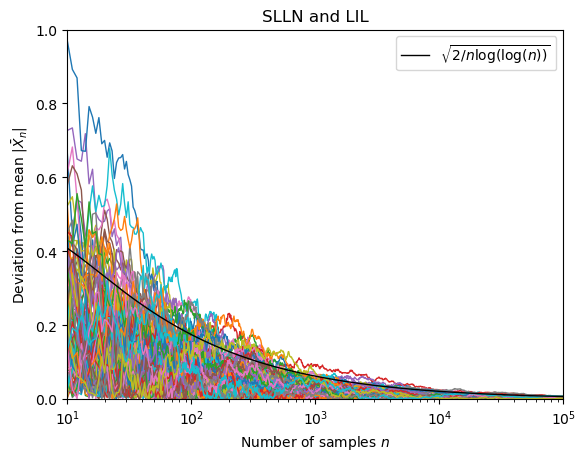

In [7]:
fig, ax = plt.subplots()

ax.plot(X,iterlog(X),color="black",lw =1,zorder=5,label=r"$\sqrt{2  /n \log ( \log (n))}$") #plot the iterated logarithm
for path in paths:
    ax.plot(ns,np.abs(path[ns-1]),lw=1) #plot the path

ax.set_xlabel("Number of samples $n$")
ax.set_ylabel(r"Deviation from mean $|\bar{X}_n |$")
ax.set_xscale("log")
ax.set_xlim(10**1,10**max_pow)
ax.set_ylim(0,1)
plt.legend()
plt.title("SLLN and LIL")
plt.show()

# Optimized Code

In [8]:
import numpy as np 
from matplotlib import pyplot as plt 
import numba as nb 
import threading

In [9]:
threadnr = 8 #number of threads to use
M = 10*threadnr #number of paths to calculate (expected to be integer multiple of the thread number)
min_pow = 5 #minimum power of 10 for which n will be displayed
max_pow = 8 #maximum power of 10 for which n will be displayed

In [10]:
X= np.logspace(min_pow,max_pow,base=10,num=1000) #create array of equally spaced numbers on log scale for plotting of the iterated logarithm
ns = np.unique(np.round(X).astype(np.int64)) #create array of equally spaced integers on log scale for plotting of the paths
diffs = np.diff(ns) #array of differences in ns i.e. diffs[i] = ns[i+1]-ns[i]

In [11]:
@nb.jit(nopython=True,fastmath=True,nogil=True)
def partial_sum(rng,n):
    """take a numpy an instance rng of the np.random.Generator() class and sum n normally distributed samples drawn from rng"""
    var=0
    for i in range(n):
        var+=rng.normal()
    return var

In [12]:
@nb.jit(nopython=True,fastmath=True,nogil=True)
def generate_path(paths,rng):
    """take an array paths and save the relevant path values in it for paths.shape[0] different paths. Uses random samples from rng."""
    for j in range(paths.shape[0]):
        paths[j,0]=partial_sum(rng,ns[0])
        for ind,val in enumerate(diffs):
            paths[j,ind+1] = partial_sum(rng,val)+paths[j,ind]

In [13]:
paths = np.empty(shape=(M,len(ns))) #array to save the values of the paths
chunk_len = paths.shape[0]//threadnr #number of paths each thread calculates 
chunks = [paths[i*chunk_len:(i+1)*chunk_len,:] for i in range(threadnr)] #one slice of the paths array for each thread to execute generate_path on

In [14]:
rngs = [np.random.Generator(np.random.SFC64()) for i in range(threadnr)] # one rng for each thread

In [15]:
threads = [threading.Thread(target=generate_path,args=([chunks[i],rngs[i]])) for i in range(threadnr)]

In [16]:
for thread in threads:
    thread.start()#start the thread
for thread in threads:
    thread.join()#wait for the thread to finish

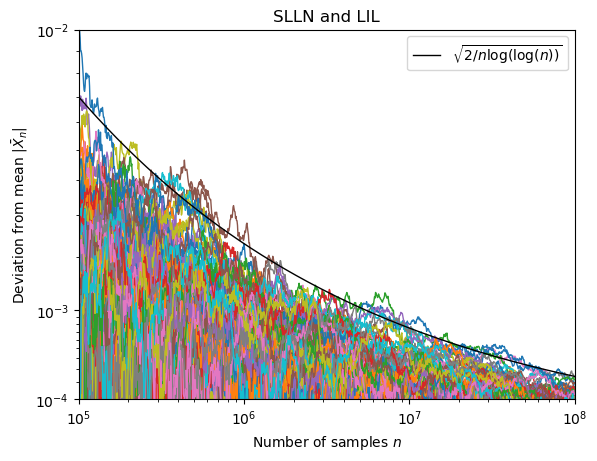

In [17]:
fig, ax = plt.subplots()

ax.plot(X,iterlog(X),color="black",lw =1,zorder=5,label=r"$\sqrt{2  /n \log ( \log (n))}$") #plot the iterated logarithm

for p in paths:
    ax.plot(ns,np.abs(p/ns),lw=1) #plot the path

ax.set_xlabel("Number of samples $n$")
ax.set_ylabel(r"Deviation from mean $|\bar{X}_n |$")
ax.set_xscale("log")
ax.set_xlim(10**min_pow,10**max_pow)

def f(x):
    return x**(1/2)

def g(x):
    return x**2

ax.set_yscale("function", functions=(f, g))
ax.set_ylim(10**-4,10**-2)
ax.set_yticks([10**-2,10**-3,10**-4])
ax.set_yticks([(i+1)*10**(-1*j) for j in [3,4] for i in range(9) ],minor=True)
ax.set_yticklabels(["$10^{-2}$","$10^{-3}$","$10^{-4}$"])

plt.legend()
plt.title("SLLN and LIL")
plt.show()